# DCGAN

- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks(https://arxiv.org/pdf/1511.06434.pdf)

![alt text](http://2.bp.blogspot.com/-oMyhHfxOqiE/WKF4KlVYWJI/AAAAAAAABRs/6BDIypy1hn0U8MGRFxfVaXOcQDO7vX1cQCK4B/s1600/dcgan-architecture.PNG)

## 1. Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

## 2. Hyperparameter setting

In [2]:
# Set Hyperparameters
# change num_gpu to the number of gpus you want to use

epoch = 100
batch_size = 512
learning_rate = 0.0002

## 3. Data Setting

In [3]:
# Download Data

mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                        ]),
                        target_transform=None,
                        download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

## 4. Generator

In [4]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*256),
             nn.BatchNorm1d(7*7*256),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(OrderedDict([
                        ('conv1', nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1)),     # batch x 128 x 14 x 14
                        ('bn1', nn.BatchNorm2d(128)),
                        ('relu1', nn.ReLU()),
                        ('conv2', nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1)),               # batch x 64 x 14 x 14
                        ('bn2', nn.BatchNorm2d(64)),    
                        ('relu2', nn.ReLU()),
            ]))
        self.layer3 = nn.Sequential(OrderedDict([
                        ('conv3',nn.ConvTranspose2d(64,16,kernel_size=4,stride=2,padding=1)),        # batch x 16 x 28 x 28
                        ('bn3',nn.BatchNorm2d(16)),    
                        ('relu3',nn.ReLU()),
                        ('conv4',nn.Conv2d(16,1,kernel_size=3,stride=1,padding=1)),                  # batch x 1 x 28 x 28
                        ('relu4',nn.Tanh())
            ]))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
        
        
    def forward(self,z):
        out = self.layer1(z)
        out = out.view(batch_size,256,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

## 5. Discriminator

In [5]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        ('conv1',nn.Conv2d(1,8,kernel_size=3,stride=1,padding=1)),   # batch x 8 x 28 x 28
                        #('bn1',nn.BatchNorm2d(8)),    
                        ('relu1',nn.LeakyReLU()),
                        ('conv2',nn.Conv2d(8,16,kernel_size=3,stride=2,padding=1)),  # batch x 16 x 14 x 14
                        ('bn2',nn.BatchNorm2d(16)),    
                        ('relu2',nn.LeakyReLU()),
        ]))
        self.layer2 = nn.Sequential(OrderedDict([
                        ('conv3',nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)), # batch x 32 x 14 x 14
                        ('bn3',nn.BatchNorm2d(32)),
                        ('relu3',nn.LeakyReLU()),
                        ('conv4',nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1)), # batch x 64 x 7 x 7
                        ('bn4',nn.BatchNorm2d(64)),
                        ('relu4',nn.LeakyReLU())
        ]))
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        out = self.fc(out)
        return out

## 6. Put instances on Multi-gpu

In [6]:
# DataParallel 함수를 이용해 멀티 GPU에 모델을 올릴 수 있습니다.
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device_ids: default all devices / output_device: default device 0 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

generator = nn.DataParallel(Generator()).to(device)
discriminator = nn.DataParallel(Discriminator()).to(device)

cuda


## 7. Check layers

In [7]:
# Get parameter list by using class.state_dict().keys()

gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

for i in gen_params:
    print(i)

module.layer1.0.weight
module.layer1.0.bias
module.layer1.1.weight
module.layer1.1.bias
module.layer1.1.running_mean
module.layer1.1.running_var
module.layer1.1.num_batches_tracked
module.layer2.conv1.weight
module.layer2.conv1.bias
module.layer2.bn1.weight
module.layer2.bn1.bias
module.layer2.bn1.running_mean
module.layer2.bn1.running_var
module.layer2.bn1.num_batches_tracked
module.layer2.conv2.weight
module.layer2.conv2.bias
module.layer2.bn2.weight
module.layer2.bn2.bias
module.layer2.bn2.running_mean
module.layer2.bn2.running_var
module.layer2.bn2.num_batches_tracked
module.layer3.conv3.weight
module.layer3.conv3.bias
module.layer3.bn3.weight
module.layer3.bn3.bias
module.layer3.bn3.running_mean
module.layer3.bn3.running_var
module.layer3.bn3.num_batches_tracked
module.layer3.conv4.weight
module.layer3.conv4.bias


## 8. Set Loss function & Optimizer

In [8]:
# loss function, optimizers, and labels for training

loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr=learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

ones_label = torch.ones(batch_size,1).to(device)
zeros_label = torch.zeros(batch_size,1).to(device)

## 9. Restore Model

In [9]:
# model restore if any

import os

try:
  os.mkdir("./model")
except:
  pass

try:
  os.mkdir("./result")
except:
  pass

try:
    #generator, discriminator = torch.load('./model/dcgan.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass
  



--------model restored--------



## 10. Train Model

In [10]:
# train

for i in range(epoch):
    for j,(image,label) in enumerate(train_loader):
        image = image.to(device)
        
        # generator
        gen_optim.zero_grad()
        
        z = init.normal_(torch.Tensor(batch_size,100),mean=0,std=0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real
        gen_loss.backward()
        gen_optim.step()
    
        # discriminator
        dis_optim.zero_grad()
        
        z = init.normal_(torch.Tensor(batch_size,100),mean=0,std=0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        dis_real = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        dis_loss.backward()
        dis_optim.step()
    
        # model save
        if j % 1000 == 0:
            torch.save([generator,discriminator],'./model/dcgan.pkl')
            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            v_utils.save_image(gen_fake.cpu().data[0:25],"./result/gen_{}_{}.png".format(i,j), nrow=5)
            
    #image_check(gen_fake.cpu())

0th iteration gen_loss: 0.3622601330280304 dis_loss: 0.8978231549263


/home/theia/.local/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/theia/.local/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1th iteration gen_loss: 0.6638056635856628 dis_loss: 0.1815345287322998
2th iteration gen_loss: 0.7152919769287109 dis_loss: 0.1215718537569046
3th iteration gen_loss: 0.8630366325378418 dis_loss: 0.07560877501964569
4th iteration gen_loss: 0.9230764508247375 dis_loss: 0.023340638726949692
5th iteration gen_loss: 0.9995739459991455 dis_loss: 0.001373699982650578
6th iteration gen_loss: 0.9998968243598938 dis_loss: 0.000524013361427933
7th iteration gen_loss: 0.894067645072937 dis_loss: 0.002798311645165086
8th iteration gen_loss: 0.9675477743148804 dis_loss: 0.00826541893184185
9th iteration gen_loss: 0.9997848868370056 dis_loss: 0.00036513659870252013
10th iteration gen_loss: 0.9999666213989258 dis_loss: 8.791234722593799e-05
11th iteration gen_loss: 0.9999325275421143 dis_loss: 4.658460238715634e-05
12th iteration gen_loss: 0.9997439980506897 dis_loss: 0.00015139937750063837
13th iteration gen_loss: 0.9998294711112976 dis_loss: 8.502708078594878e-05
14th iteration gen_loss: 0.9999871

0
['./result/gen_0_100.png', './result/gen_0_0.png']


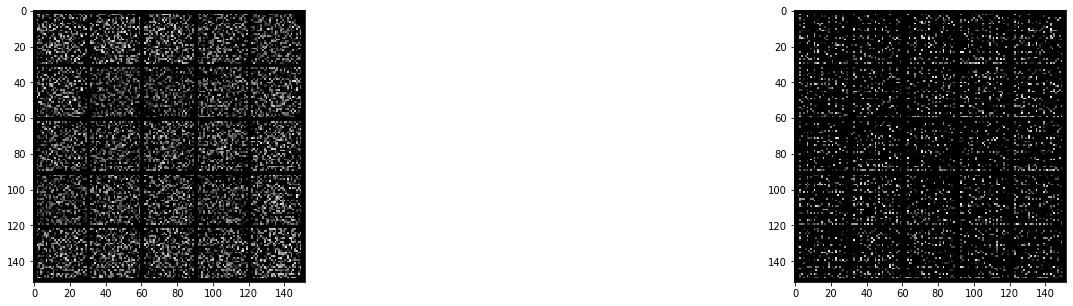

5
['./result/gen_5_0.png', './result/gen_5_100.png']


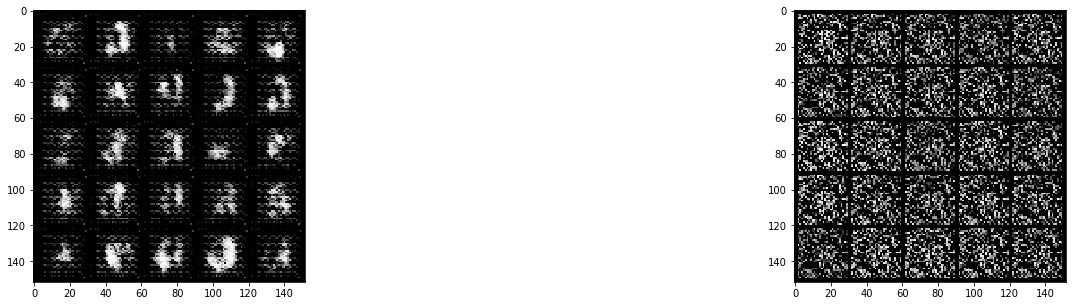

10
['./result/gen_10_0.png', './result/gen_10_100.png']


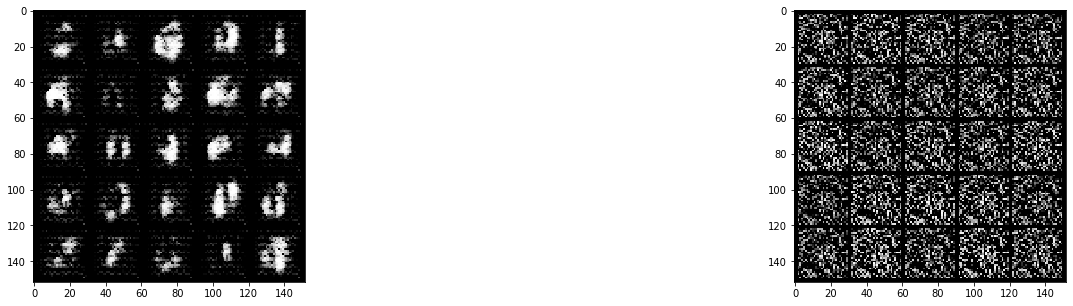

15
['./result/gen_15_0.png', './result/gen_15_100.png']


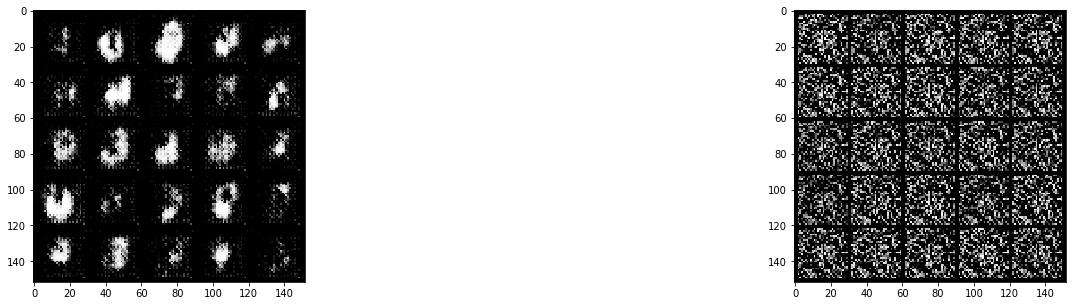

20
['./result/gen_20_0.png', './result/gen_20_100.png']


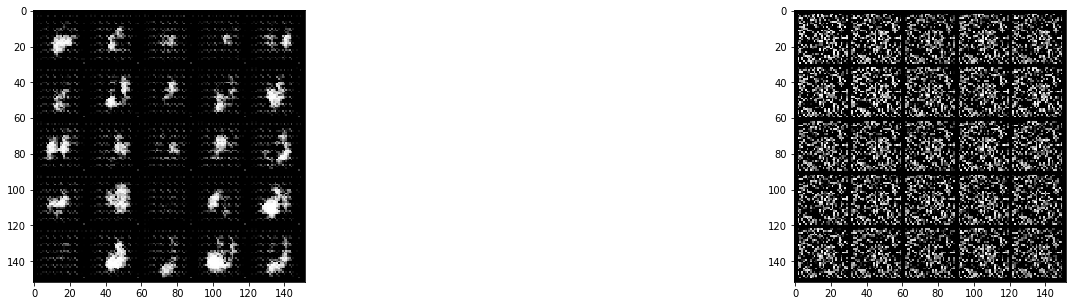

25
['./result/gen_25_0.png', './result/gen_25_100.png']


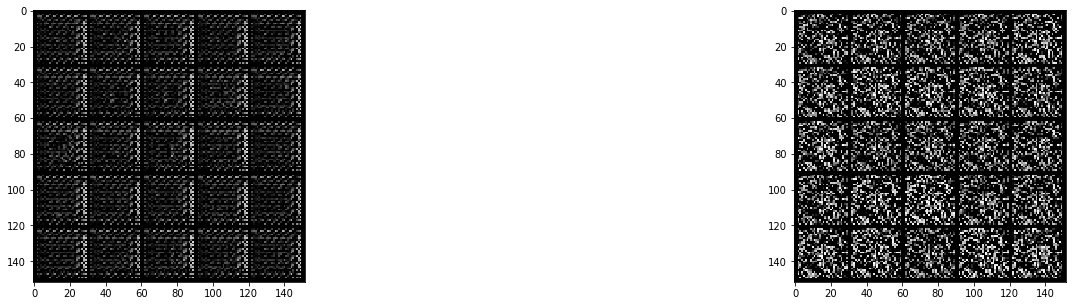

30
['./result/gen_30_0.png', './result/gen_30_100.png']


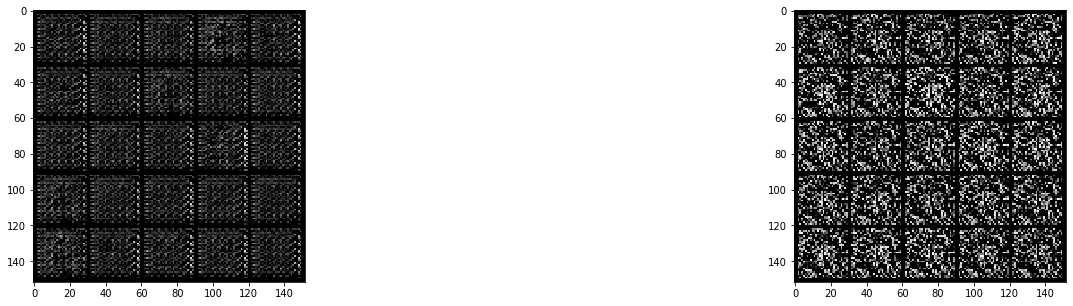

35
['./result/gen_35_0.png', './result/gen_35_100.png']


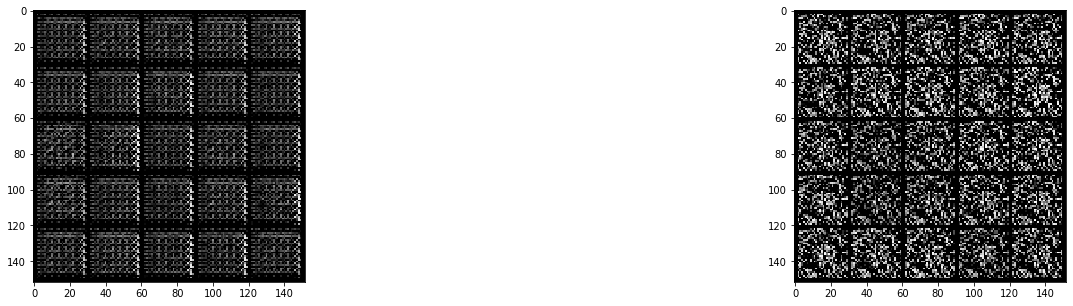

40
['./result/gen_40_0.png', './result/gen_40_100.png']


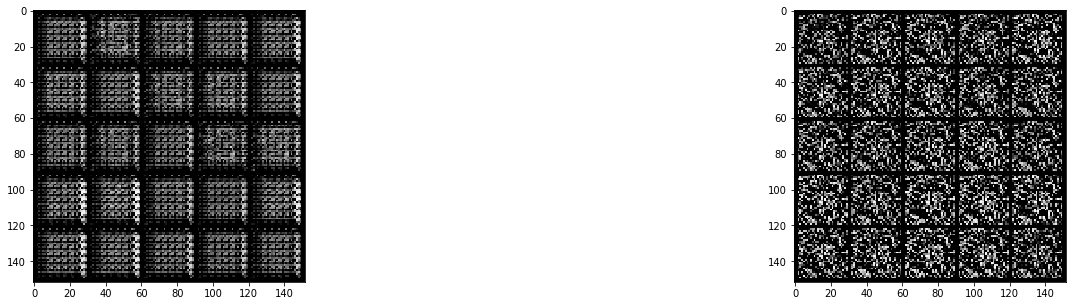

45
['./result/gen_45_0.png', './result/gen_45_100.png']


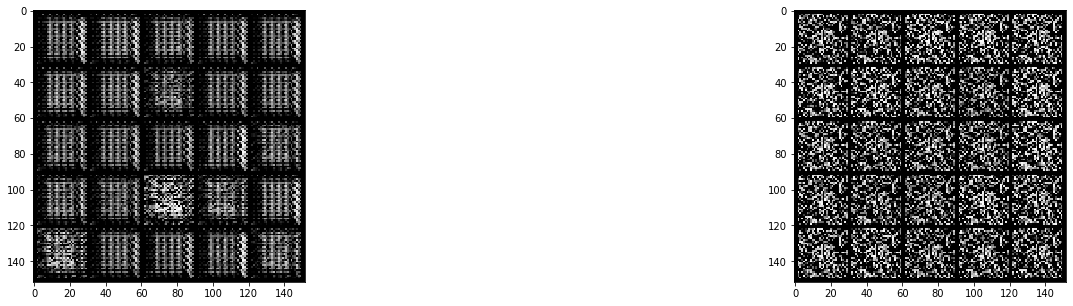

50
['./result/gen_50_0.png']


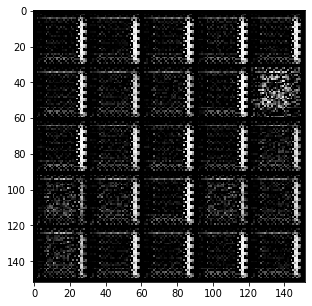

55
['./result/gen_55_0.png']


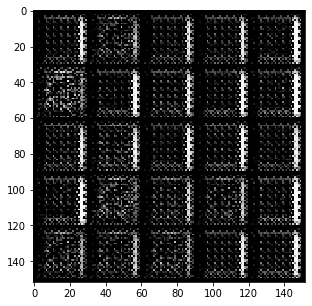

60
['./result/gen_60_0.png']


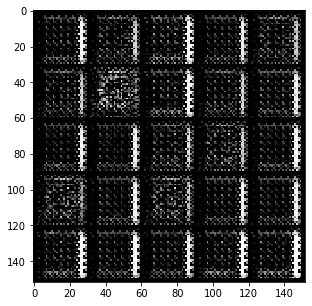

65
['./result/gen_65_0.png']


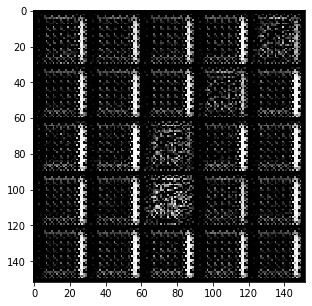

70
['./result/gen_70_0.png']


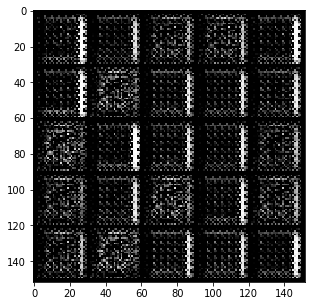

75
['./result/gen_75_0.png']


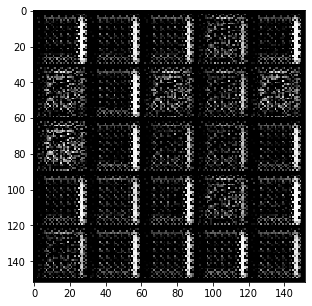

80
['./result/gen_80_0.png']


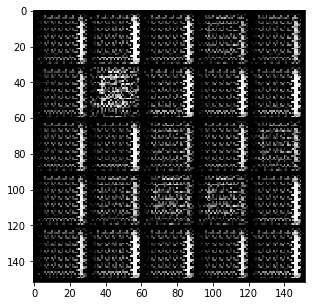

85
['./result/gen_85_0.png']


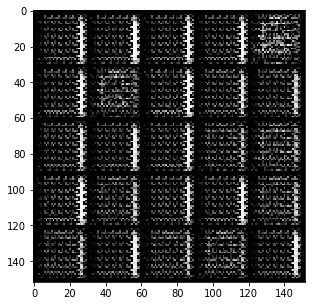

90
['./result/gen_90_0.png']


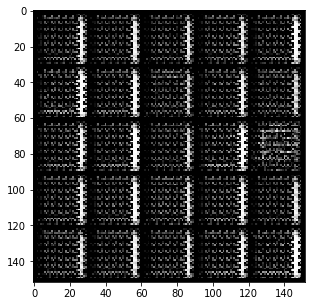

95
['./result/gen_95_0.png']


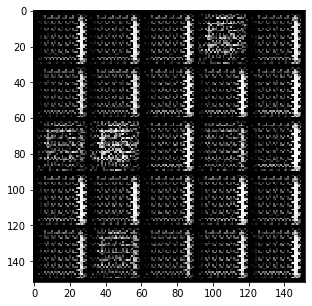

In [11]:
from glob import glob 

for i in range(0,epoch,5):
  print(i)
  file_list = glob("./result/gen_{}_*.png".format(i))
  print(file_list)
  
  img_per_epoch = len(file_list)
  
  plt.figure(figsize=(25,5))
  for idx,j in enumerate(file_list):
    img = plt.imread(j)
    plt.subplot(1,img_per_epoch,idx+1)
    plt.imshow(img)
  plt.show()